Libs

In [1]:
import pandas as pd 
import numpy as np
from itertools import product
import matplotlib.pyplot as plt

Load the dataset

In [2]:
df = pd.read_csv('dataset/consensus_adj_mat.csv')
df = df.drop('Unnamed: 0',axis=1)
df 

,Akt,Erk,Jnk,Mek,P38,PIP2,PIP3,PKA,PKC,Plcg,Raf
0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,1,0,0
6,1,0,0,0,0,1,0,0,0,1,0
7,1,1,1,1,1,0,0,0,0,0,1
8,0,0,1,1,1,0,0,0,0,0,1
9,0,0,0,0,0,1,0,0,1,0,0


In [3]:
df_1 = pd.read_csv('dataset/sachs_bin.csv')
df_1 = df_1.astype(int)
akt_obs = df_1['Akt']
erk_obs = df_1['Erk']
jnk_obs = df_1['Jnk']
mek_obs = df_1['Mek']
p38_obs = df_1['P38']
pip2_obs = df_1['PIP2']
pip3_obs = df_1['PIP3']
pka_obs = df_1['PKA']
pkc_obs = df_1['PKC']
df_1

,Akt,Erk,Jnk,Mek,P38,PIP2,PIP3,PKA,PKC
0,0,0,1,0,1,0,1,0,1
1,0,0,1,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0
4,1,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
848,0,0,0,0,0,0,0,0,1
849,0,0,1,0,1,0,1,0,0
850,0,0,0,1,0,0,1,0,0
851,0,0,0,0,1,0,1,0,1


Forward simulation

In [4]:
# Define the nodes in the network
nodes = ['Akt', 'Erk', 'Jnk', 'Mek', 'P38', 'PIP2', 'PIP3', 'PKA', 'PKC', 'PLCg', 'Raf']

# Define the parents of each node (based on the network structure)
parents = {
    'Akt': ['PIP3', 'PKA'],
    'Erk': ['Mek', 'PKA'],
    'Jnk': ['PKA', 'PKC'],
    'Mek': ['PKA', 'PKC', 'Raf'],
    'P38': ['PKA', 'PKC'],
    'PIP2': ['PIP3', 'PLCg'],
    'PIP3': [],
    'PKA': [],
    'PKC': ['PIP2', 'PLCg'],
    'PLCg': ['PIP3'],
    'Raf': ['PKA', 'PKC']
}

# Define the initial state of the network
state = {node: np.random.choice([0, 1]) for node in nodes}

# Define the CPDs for each node (these would be based on your data)
cpds = {node: {parent_state: np.random.dirichlet(np.ones(2)) for parent_state in product([0, 1], repeat=len(parents[node]))} for node in nodes}

def simulate_step(state, cpds, parents):
    """
    Simulate a single step of the network.
    """
    new_state = state.copy()
    for node in state:
        parent_state = tuple(state[parent] for parent in parents[node])
        # Flatten the p array
        p = np.ravel(cpds[node][parent_state])
        new_state[node] = np.random.choice([0, 1], p=p)
    return new_state

Simulation

In [5]:
# Simulate the network over time and store the states
states = []
for t in range(20):
    state = simulate_step(state, cpds, parents)
    states.append(state)
print(state)

{'Akt': 0, 'Erk': 0, 'Jnk': 1, 'Mek': 1, 'P38': 1, 'PIP2': 1, 'PIP3': 1, 'PKA': 0, 'PKC': 0, 'PLCg': 1, 'Raf': 0}


Visualization

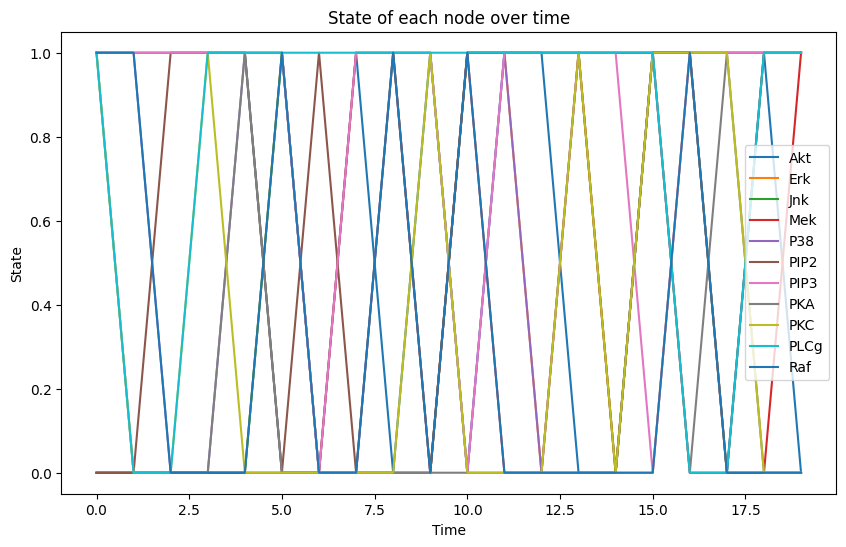

In [6]:
# Convert the states to a numpy array for easier manipulation
states_array = np.array([[state[node] for node in nodes] for state in states])

# Plot the state of each node over time
plt.figure(figsize=(10, 6))
for i, node in enumerate(nodes):
    plt.plot(states_array[:, i], label=node)
plt.legend()
plt.xlabel('Time')
plt.ylabel('State')
plt.title('State of each node over time')
plt.show()